# Frailty Risk Modeling v2 (using converted Gene Symbols)
### Author: Shehbeel Arif
### Purpose: To develop an ML or statistical model to determine a patient's frailty risk status based on the muscle gene expression data.

---

## Load libraries

In [2]:
# Libraries for data handling
import numpy as np
import pandas as pd


# Library for splitting data into Training and Testing datasets
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

# Import Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier
# Import Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression


# Import sklearn package to assess model accuracy
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from statistics import mean, stdev


# Library for visualizations
from umap.umap_ import UMAP # ! pip install umap-learn
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Data Preprocessing

In [5]:
# Load data
data_dir = '/Users/shehbeel/Documents/frailty-clinical-model/data/'
data_dir2 = '/Users/shehbeel/Documents/frailty-clinical-model/analyses/01-convert-ensembl-ids/results/'
meta = pd.read_csv(data_dir + 'GSE144304_meta.txt', delimiter='\t')
counts = pd.read_csv(data_dir2 + 'GSE144304_raw_counts_with_genes.csv', index_col='gene_symbol')

# Transpose counts
counts = counts.T
counts = counts.reset_index()

# Merge counts and meta data
df = pd.merge(meta, counts, left_on='sample_name', right_on='index').drop(['index'], axis=1)

# Sanity check
df

,sample_name,gender,treatment,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,...,MIR6787,MIR4793,MIR935,MIR5006,MIR4722,MIR92B,MIR943,MIR7847,MIR6785,MIR4467
0,s301,male,frail,99,20,284,101,19,15,252,...,0,0,0,0,0,0,0,0,0,0
1,s302,male,frail,54,3,381,127,7,39,113,...,0,0,0,0,0,0,0,0,0,0
2,s303,male,frail,44,2,303,123,9,16,147,...,0,0,0,0,0,0,0,0,0,0
3,s304,male,frail,59,3,306,146,1,6,92,...,0,0,0,1,0,0,0,0,0,0
4,s305,male,frail,52,0,402,103,10,31,115,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,s530,female,young,54,0,349,139,5,4,51,...,0,0,0,0,0,0,0,0,0,0
76,s531,male,young,73,0,395,115,16,13,103,...,0,0,0,0,0,0,0,0,0,0
77,s401,male,fit,55,2,252,97,4,17,48,...,0,0,0,1,0,0,0,0,0,0
78,s404,male,fit,72,4,204,99,21,31,196,...,0,0,0,0,0,0,0,0,0,0


## Split into Training and Testing set

In [6]:
# Split the dataset into training data and labels
# X = df.loc[:, df.columns != 'treatment']
# X = X.iloc[:,1:]
X = df.iloc[:,3:].values
y = df.loc[:, df.columns == 'treatment'].values.ravel()

# Sanity check
#print(X[:5])
#print(y[:5])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)

#Sanity check
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(64, 35835) (16, 35835) (64,) (16,)


---

## Visualize the data

<AxesSubplot:xlabel='0', ylabel='1'>

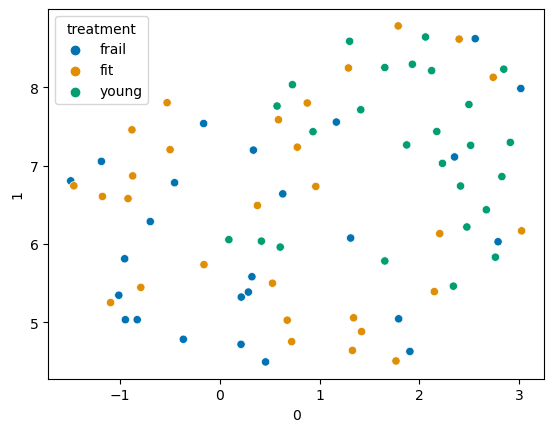

In [7]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.iloc[:,3:])
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")

---

## Build Baseline Model (Random Forest)

In [8]:
# Instantiate the Random Forest Classifier
rfc = RandomForestClassifier(max_depth=3, random_state=123)

# Fit the classifier to data
rfc.fit(X_train, y_train)

# Predict on test dataset
y_pred = rfc.predict(X_test)

# Accuracy of model
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(rfc.predict_proba(X_test))

Accuracy: 0.75
[[0.48903928 0.41071921 0.10024151]
 [0.23443644 0.15204002 0.61352354]
 [0.52673778 0.34147436 0.13178786]
 [0.63850027 0.23780459 0.12369514]
 [0.11680692 0.06466296 0.81853012]
 [0.56883415 0.36474872 0.06641712]
 [0.10673285 0.09029158 0.80297557]
 [0.34595077 0.5014411  0.15260813]
 [0.5174596  0.38605718 0.09648322]
 [0.58488509 0.3313657  0.08374921]
 [0.17201865 0.10202382 0.72595753]
 [0.55647519 0.2310799  0.21244491]
 [0.50078116 0.42836962 0.07084922]
 [0.3523583  0.08187388 0.56576782]
 [0.40075592 0.37994551 0.21929858]
 [0.44317484 0.33103137 0.2257938 ]]


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

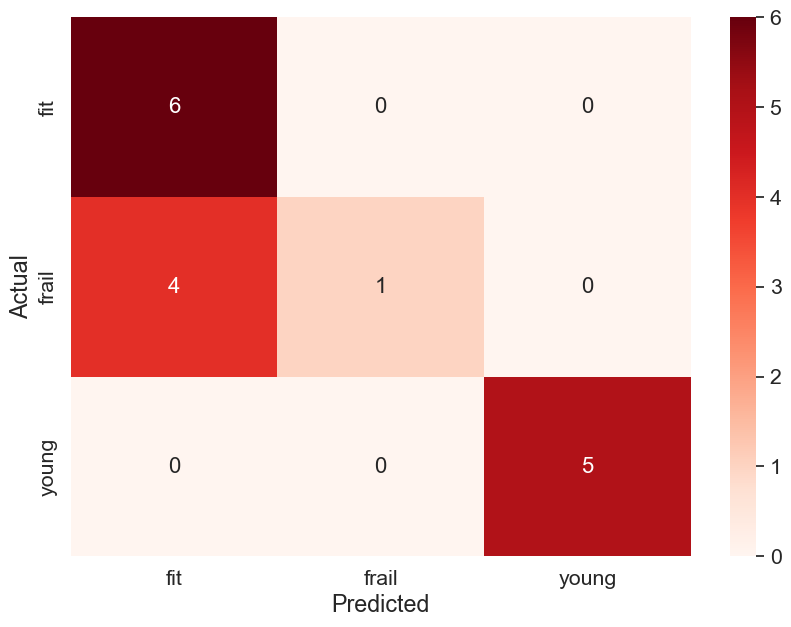

In [9]:
# Build confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [61]:
# What are the most important features?
feature_list = df.columns
feature_list = feature_list.drop(['sample_name', 'gender', 'treatment'])

imp_features = pd.Series(rfc.feature_importances_, index=feature_list)

imp_genes = imp_features.sort_values(ascending=False).to_frame().reset_index()
imp_genes.columns = ["features", "importance"]

imp_genes_fil = imp_genes[~(imp_genes == 0.000000).any(axis=1)]
imp_genes_fil

,features,importance
0,HOXA7,0.010389
1,GCNT2,0.009772
2,TENM3,0.009063
3,TRNAU1AP,0.009051
4,SPECC1L,0.008920
...,...,...
489,HP1BP3,0.000314
490,CFH,0.000262
491,DNAJC30,0.000259
492,MDC1,0.000246


In [64]:
df[imp_genes_fil['features']]

,HOXA7,GCNT2,TENM3,TRNAU1AP,SPECC1L,DPF2,PAF1,H3-3B,GABPB2,SLC4A4,...,DPY19L2P2,RPS6,ZNF880,DM1-AS,TIPARP,HP1BP3,CFH,DNAJC30,MDC1,SELE
0,221,20,108,125,196,368,493,1876,200,55,...,5,4338,36,12,108,1415,252,93,210,0
1,326,89,142,91,194,372,460,1398,187,42,...,10,4865,35,5,108,1206,113,109,202,0
2,235,75,78,121,179,368,453,1734,204,29,...,7,4306,12,12,73,1319,147,106,231,2
3,288,16,111,123,227,536,642,2438,169,50,...,6,5419,22,8,134,1549,92,93,246,0
4,321,42,99,106,237,440,534,2006,219,46,...,3,5636,20,4,98,1204,115,127,228,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,127,8,29,74,136,314,431,1305,141,65,...,3,5438,17,3,128,1251,51,77,174,0
76,209,3,57,55,95,275,350,983,128,81,...,11,4664,33,2,87,1444,103,85,174,0
77,208,16,77,117,137,328,552,1241,192,54,...,4,5657,28,1,46,1105,48,44,219,0
78,263,32,93,139,145,355,435,1627,231,34,...,9,6540,21,4,94,1276,196,62,234,0


<AxesSubplot:xlabel='0', ylabel='1'>

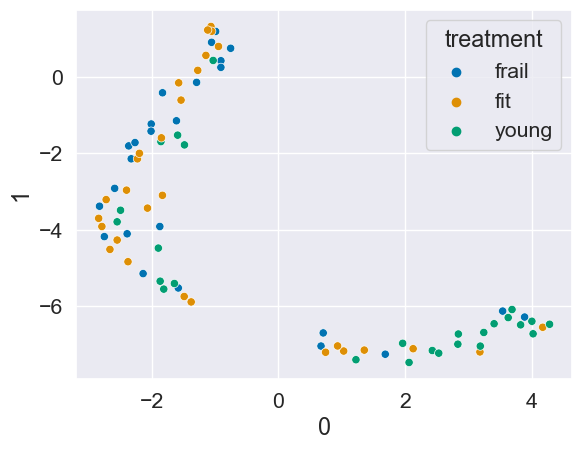

In [65]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df[imp_genes_fil['features']])
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")

## Random Forest (CV)

In [90]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
lst_accu_stratified = []

rfc = RandomForestClassifier(max_depth=3, random_state=123)

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    rfc.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(rfc.score(x_test_fold, y_test_fold))
  
# Print the output
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.625, 0.5, 0.75, 0.625, 0.75, 0.75, 0.875, 0.5, 0.875, 0.875]

Maximum Accuracy That can be obtained from this model is: 87.5 %

Minimum Accuracy: 50.0 %

Overall Accuracy: 71.25 %

Standard Deviation is: 0.1449377260910507


---

## Logistic Regression Model (CV)

In [89]:
# Create StratifiedKFold object.
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=123)
lst_accu_stratified = []

lr = LogisticRegression(max_iter=500, random_state=123)

for train_index, test_index in skf.split(X, y):
    x_train_fold, x_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    lr.fit(x_train_fold, y_train_fold)
    lst_accu_stratified.append(lr.score(x_test_fold, y_test_fold))
  
# Print the output
print('List of possible accuracy:', lst_accu_stratified)
print('\nMaximum Accuracy That can be obtained from this model is:',
      max(lst_accu_stratified)*100, '%')
print('\nMinimum Accuracy:',
      min(lst_accu_stratified)*100, '%')
print('\nOverall Accuracy:',
      mean(lst_accu_stratified)*100, '%')
print('\nStandard Deviation is:', stdev(lst_accu_stratified))

List of possible accuracy: [0.625, 0.625, 0.375, 0.5, 0.625, 0.5, 0.5, 0.625, 0.625, 0.625]

Maximum Accuracy That can be obtained from this model is: 62.5 %

Minimum Accuracy: 37.5 %

Overall Accuracy: 56.25 %

Standard Deviation is: 0.08838834764831845


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

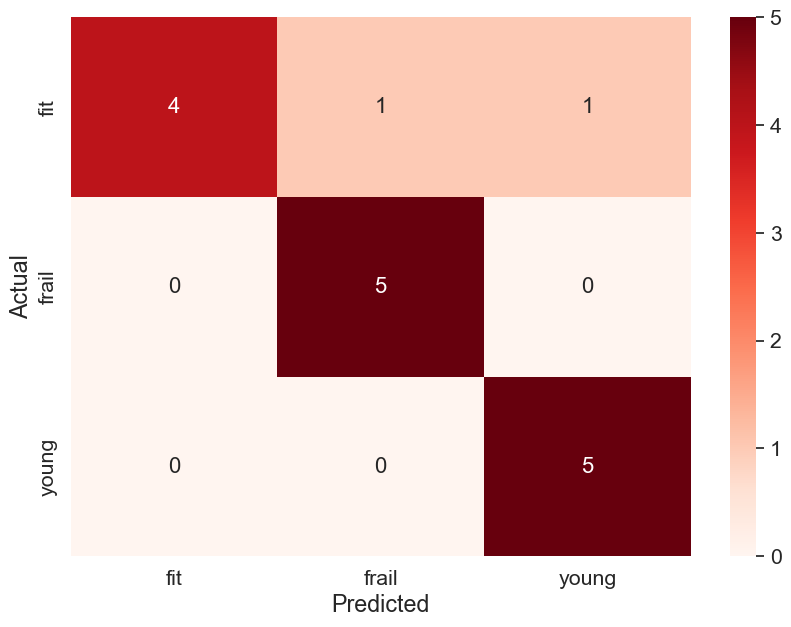

In [13]:
# Build confusion matrix
y_pred = lr.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm = pd.DataFrame(cm, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm, cmap="Reds", annot=True,annot_kws={"size": 16})# font size

In [14]:
# What are the most important features?
feature_list = df.columns
feature_list = feature_list.drop(['sample_name', 'gender', 'treatment'])

imp_features = pd.Series(lr.coef_[0], index=feature_list)

imp_genes = imp_features.sort_values(ascending=False).to_frame().reset_index()
imp_genes.columns = ["features", "importance"]

imp_genes_fil = imp_genes[~(imp_genes == 0.000000).any(axis=1)]
imp_genes_fil

,features,importance
0,COX3,0.000496
1,CKM,0.000441
2,MYBPC1,0.000373
3,ND2,0.000360
4,TNNT1,0.000308
...,...,...
35830,ND4,-0.000287
35831,ND1,-0.000310
35832,ATP2A2,-0.000348
35833,CYTB,-0.000353


In [ ]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df[imp_genes_fil['features']])
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")

---

## Feature Selection

In [55]:
from sklearn.feature_selection import VarianceThreshold

selector = VarianceThreshold(threshold=500000)
selector.fit(df.iloc[:,3:])
X_ = df.iloc[:,3:].iloc[:,selector.get_support()]
X_

,SLC7A2,POLDIP2,HSPB6,PDK4,PDK2,PHTF2,SCN4A,NFIX,RPS20,CSDE1,...,NEAT1,OIP5-AS1,MTATP6P1,C4orf54,ACTN3,MALAT1,NORAD,DYNLL2,MIR133A1HG,TXNIP
0,3211,2334,12829,11584,2408,2268,4626,4873,2967,27417,...,9541,2398,23866,2255,8880,112476,4361,3526,2216,22220
1,2449,2978,11777,6236,3661,1292,3007,3158,3034,31109,...,11258,3110,33103,1237,3686,132066,3756,4443,2059,13459
2,3507,2799,13621,4446,2599,1914,4246,3934,2341,26920,...,14472,2915,24687,3166,11128,105400,3613,3561,3046,8509
3,4350,3163,7067,4118,3208,1950,5302,3554,3504,30190,...,12878,3035,28796,2713,14111,142029,4465,3683,2515,15215
4,2556,3087,8527,14603,3426,1779,3134,2744,3379,30879,...,11347,3056,20878,2107,216,156032,3467,4160,2045,8729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2793,2406,7584,2178,2547,2127,3360,3989,2093,30237,...,8034,2859,27299,3193,3750,110913,4058,2888,2073,12383
76,2339,2487,5802,9318,2291,2108,3298,3982,1843,30243,...,4699,4934,41023,2326,5151,67401,3483,3301,1750,13109
77,3185,2256,6074,11641,2304,1803,3404,3137,2892,31321,...,12549,2998,18842,1510,10257,116049,3797,3218,2880,10891
78,3553,2344,7421,6137,2949,1490,3266,3311,2348,25914,...,9939,3331,22033,1481,3506,89678,2852,2556,4823,8792


<AxesSubplot:xlabel='0', ylabel='1'>

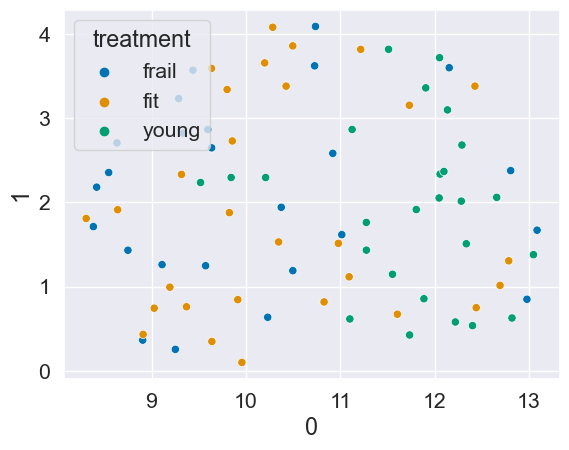

In [56]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(X_)
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")

---

## Recursive Feature Elimination (100 genes)

In [66]:
from sklearn.feature_selection  import RFE

model = RandomForestClassifier(max_depth=3, random_state=123)
rfe = RFE(model, n_features_to_select=100)
rfe.fit(X, y)
y_pred = rfe.predict(X)

In [71]:
#rfe.support_
rfe.ranking_

array([35736, 35735, 35734, ..., 30112, 30804, 31213])

In [77]:
rfe_X = df.iloc[:,3:].iloc[:,rfe.support_]
rfe_X

,RNF115,MIR3156-2,MIR1269B,MIR4435-1,MIR4436A,LINC01892,MIR548V,MIR5697,MIR4304,MIR5690,...,GGNBP2,ZNF229,LOC101929140,DHRS11,ACACA,MRPL45,LOC645967,HEIH,EBLN3P,LOC101929130
0,1707,0,0,0,0,0,0,0,0,2,...,498,23,8,98,171,395,9,83,286,43
1,1546,0,0,0,0,0,0,3,0,1,...,519,15,13,144,133,428,5,104,267,6
2,1616,0,0,0,0,0,0,0,0,8,...,482,28,8,127,132,367,9,78,262,33
3,1697,0,0,0,0,0,0,2,0,3,...,655,23,9,120,169,402,3,108,344,25
4,2187,0,0,0,0,0,0,1,0,0,...,464,21,7,113,169,413,6,84,275,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1482,0,0,0,0,0,0,1,0,4,...,357,20,4,82,117,373,12,50,273,53
76,1566,0,0,0,0,0,0,3,0,4,...,328,19,5,121,141,396,8,63,300,30
77,2252,0,0,0,0,0,0,0,0,3,...,340,20,6,86,119,347,10,71,192,3
78,1797,0,0,0,0,0,0,4,0,7,...,404,45,4,141,152,388,5,86,179,2


In [ ]:
rfe_X.columns

<AxesSubplot:xlabel='0', ylabel='1'>

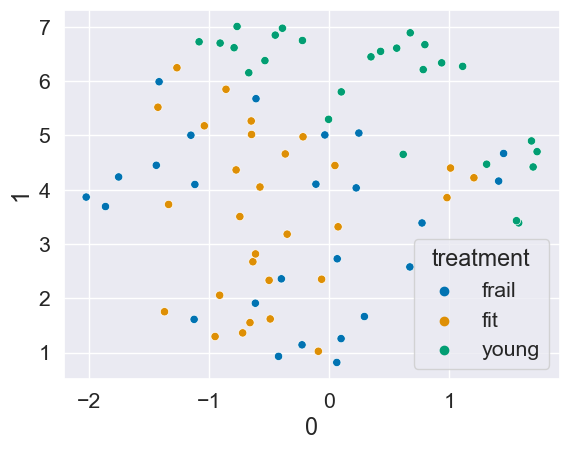

In [73]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(df.iloc[:,3:].iloc[:,rfe.support_])
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")

In [94]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(rfe_X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)

# Instantiate the Random Forest Classifier
rfc = RandomForestClassifier(max_depth=3, random_state=123)

# Fit the classifier to data
rfc.fit(X_train, y_train)

# Predict on test dataset
y_pred = rfc.predict(X_test)

# Accuracy of model
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(rfc.predict_proba(X_test))

Accuracy: 0.8125
[[0.54780149 0.3536411  0.09855741]
 [0.33193006 0.03566235 0.63240759]
 [0.4763365  0.43676357 0.08689993]
 [0.52137659 0.2855229  0.19310051]
 [0.18982638 0.10149372 0.7086799 ]
 [0.63187483 0.32727276 0.0408524 ]
 [0.15807758 0.12545292 0.7164695 ]
 [0.42045059 0.47430192 0.10524749]
 [0.4287354  0.35600303 0.21526157]
 [0.39530916 0.31448233 0.29020851]
 [0.23977854 0.24976816 0.51045331]
 [0.47591393 0.25380855 0.27027752]
 [0.38638796 0.49934755 0.11426449]
 [0.22924086 0.12921051 0.64154863]
 [0.51512572 0.34396877 0.14090551]
 [0.48996951 0.29014122 0.21988927]]


---

## Recursive Feature Elimination (20 genes)

In [86]:
from sklearn.feature_selection  import RFE

model = RandomForestClassifier(max_depth=3, random_state=123)
rfe_20 = RFE(model, n_features_to_select=20)
rfe_20.fit(X, y)
y_pred_20 = rfe.predict(X)

In [87]:
rfe20_X = df.iloc[:,3:].iloc[:,rfe_20.support_]
rfe20_X

,RNF115,STRADA,NCOA4,FXYD1,ILF3-DT,ZNF285,MAGIX,TMEM185A,EGLN2,CAHM,TAF15,KMT2B,POM121C,ATP6V1FNB,PAXIP1-DT,ZNHIT3,CCL14,GGNBP2,EBLN3P,LOC101929130
0,1707,48,2496,48,372,27,29,46,85,25,1109,370,163,10,83,325,17,498,286,43
1,1546,54,3562,50,470,18,21,73,70,22,1048,249,120,17,79,359,2,519,267,6
2,1616,44,2576,30,474,32,50,48,44,28,931,293,121,11,122,276,2,482,262,33
3,1697,65,2929,46,539,24,45,50,91,17,1236,371,159,27,76,356,2,655,344,25
4,2187,58,3281,55,561,17,37,53,67,20,1164,259,168,23,57,333,3,464,275,26
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1482,46,2256,31,352,30,22,44,35,20,894,218,117,2,57,289,0,357,273,53
76,1566,36,2965,21,316,26,15,57,44,12,776,216,90,4,43,196,3,328,300,30
77,2252,52,2043,52,412,26,19,39,49,11,1003,224,93,12,74,245,16,340,192,3
78,1797,48,2614,19,367,39,8,41,52,15,994,339,124,27,67,243,7,404,179,2


<AxesSubplot:xlabel='0', ylabel='1'>

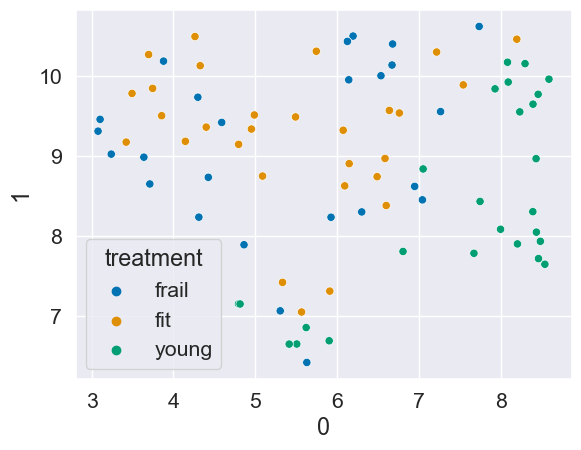

In [88]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(rfe20_X)
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")

In [93]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(rfe20_X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)

# Instantiate the Random Forest Classifier
rfc = RandomForestClassifier(max_depth=3, random_state=123)

# Fit the classifier to data
rfc.fit(X_train, y_train)

# Predict on test dataset
y_pred = rfc.predict(X_test)

# Accuracy of model
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(rfc.predict_proba(X_test))

Accuracy: 0.875
[[0.56858987 0.3686362  0.06277393]
 [0.25892308 0.07631125 0.66476568]
 [0.52622659 0.37370518 0.10006823]
 [0.6473961  0.1941037  0.1585002 ]
 [0.12943252 0.12861983 0.74194765]
 [0.6986999  0.25412291 0.04717719]
 [0.10692935 0.07291832 0.82015232]
 [0.4088971  0.54286451 0.04823839]
 [0.3631357  0.4610102  0.1758541 ]
 [0.57771767 0.21689102 0.20539131]
 [0.24766976 0.21262364 0.53970661]
 [0.53701214 0.2547235  0.20826436]
 [0.38230923 0.51316832 0.10452245]
 [0.21996679 0.05880275 0.72123046]
 [0.47961674 0.39499514 0.12538812]
 [0.49924355 0.30288852 0.19786793]]


---

## Recursive Feature Elimination (10 genes)

In [96]:
from sklearn.feature_selection  import RFE

model = RandomForestClassifier(max_depth=3, random_state=123)
rfe_10 = RFE(model, n_features_to_select=10)
rfe_10.fit(rfe20_X, y)
y_pred_10 = rfe_10.predict(rfe20_X)

In [101]:
rfe10_X = rfe20_X.iloc[:,rfe_10.support_]
rfe10_X

,RNF115,STRADA,CAHM,TAF15,KMT2B,POM121C,ATP6V1FNB,PAXIP1-DT,CCL14,GGNBP2
0,1707,48,25,1109,370,163,10,83,17,498
1,1546,54,22,1048,249,120,17,79,2,519
2,1616,44,28,931,293,121,11,122,2,482
3,1697,65,17,1236,371,159,27,76,2,655
4,2187,58,20,1164,259,168,23,57,3,464
...,...,...,...,...,...,...,...,...,...,...
75,1482,46,20,894,218,117,2,57,0,357
76,1566,36,12,776,216,90,4,43,3,328
77,2252,52,11,1003,224,93,12,74,16,340
78,1797,48,15,994,339,124,27,67,7,404


<AxesSubplot:xlabel='0', ylabel='1'>

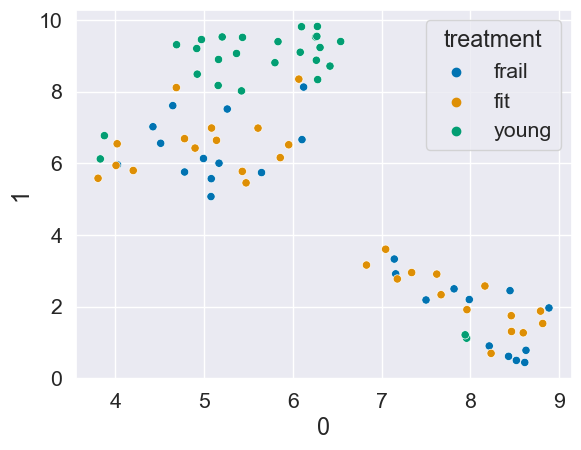

In [103]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(rfe10_X)
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")

In [102]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(rfe10_X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)

# Instantiate the Random Forest Classifier
rfc = RandomForestClassifier(max_depth=3, random_state=123)

# Fit the classifier to data
rfc.fit(X_train, y_train)

# Predict on test dataset
y_pred = rfc.predict(X_test)

# Accuracy of model
print(f'Accuracy: {metrics.accuracy_score(y_test, y_pred)}')
print(rfc.predict_proba(X_test))

Accuracy: 0.875
[[0.53240978 0.42491939 0.04267083]
 [0.19013708 0.12705493 0.68280799]
 [0.60514664 0.32807731 0.06677605]
 [0.42117291 0.32739352 0.25143357]
 [0.10575405 0.07993357 0.81431238]
 [0.612872   0.33655065 0.05057735]
 [0.19051774 0.08020158 0.72928068]
 [0.50898862 0.44236439 0.048647  ]
 [0.24053463 0.68094036 0.07852501]
 [0.59787201 0.19901765 0.20311034]
 [0.31470842 0.19509955 0.49019203]
 [0.48479674 0.4343873  0.08081595]
 [0.43382934 0.52981268 0.03635798]
 [0.0943141  0.0642765  0.84140939]
 [0.50064023 0.45735324 0.04200653]
 [0.37653057 0.43787178 0.18559765]]


---

## LASSO Regularization (L1)

In [79]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

# Set the regularization parameter C=1
lr = LogisticRegression(C=1, penalty="l1", solver='liblinear', random_state=123)
lr.fit(X,y)
model = SelectFromModel(lr, prefit=True)

X_new = model.transform(X)

# Drop columns that have values of all 0s
#selected_columns = selected_features.columns[selected_features.var() != 0]


In [81]:
pd.DataFrame(X_new)

,0,1,2,3,4,5,6,7,8,9,...,880,881,882,883,884,885,886,887,888,889
0,3211,12829,11584,2408,2418,352,2268,1927,4873,922,...,1009,4361,3526,2216,1707,22220,1109,2685,908,236
1,2449,11777,6236,3661,2236,514,1292,1856,3158,1481,...,1050,3756,4443,2059,1546,13459,1048,2303,931,61
2,3507,13621,4446,2599,2220,332,1914,1661,3934,989,...,1016,3613,3561,3046,1616,8509,931,2376,787,310
3,4350,7067,4118,3208,3160,353,1950,2030,3554,1190,...,1144,4465,3683,2515,1697,15215,1236,2558,810,31
4,2556,8527,14603,3426,1684,508,1779,2136,2744,1100,...,860,3467,4160,2045,2187,8729,1164,2284,1435,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2793,7584,2178,2547,2244,238,2127,1857,3989,849,...,1083,4058,2888,2073,1482,12383,894,2021,1015,35
76,2339,5802,9318,2291,1767,294,2108,1438,3982,1028,...,1035,3483,3301,1750,1566,13109,776,2832,1231,98
77,3185,6074,11641,2304,1891,294,1803,1909,3137,786,...,756,3797,3218,2880,2252,10891,1003,2735,486,788
78,3553,7421,6137,2949,1486,431,1490,1884,3311,889,...,1041,2852,2556,4823,1797,8792,994,2656,634,597


In [85]:
df.iloc[:,3:].iloc[:,model.get_support()]


,SLC7A2,HSPB6,PDK4,PDK2,LAMP2,SPATA20,PHTF2,SYPL1,NFIX,ST3GAL1,...,ZNF710-AS1,NORAD,DYNLL2,MIR133A1HG,RNF115,TXNIP,TAF15,NUDT3,NATD1,FAM238C
0,3211,12829,11584,2408,2418,352,2268,1927,4873,922,...,1009,4361,3526,2216,1707,22220,1109,2685,908,236
1,2449,11777,6236,3661,2236,514,1292,1856,3158,1481,...,1050,3756,4443,2059,1546,13459,1048,2303,931,61
2,3507,13621,4446,2599,2220,332,1914,1661,3934,989,...,1016,3613,3561,3046,1616,8509,931,2376,787,310
3,4350,7067,4118,3208,3160,353,1950,2030,3554,1190,...,1144,4465,3683,2515,1697,15215,1236,2558,810,31
4,2556,8527,14603,3426,1684,508,1779,2136,2744,1100,...,860,3467,4160,2045,2187,8729,1164,2284,1435,162
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2793,7584,2178,2547,2244,238,2127,1857,3989,849,...,1083,4058,2888,2073,1482,12383,894,2021,1015,35
76,2339,5802,9318,2291,1767,294,2108,1438,3982,1028,...,1035,3483,3301,1750,1566,13109,776,2832,1231,98
77,3185,6074,11641,2304,1891,294,1803,1909,3137,786,...,756,3797,3218,2880,2252,10891,1003,2735,486,788
78,3553,7421,6137,2949,1486,431,1490,1884,3311,889,...,1041,2852,2556,4823,1797,8792,994,2656,634,597


<AxesSubplot:xlabel='0', ylabel='1'>

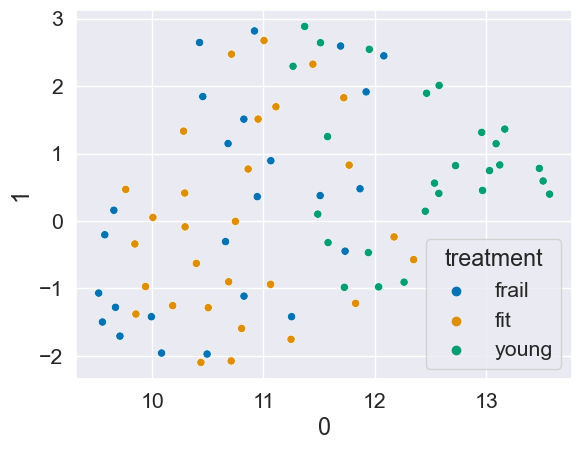

In [82]:
# Plot UMAP
umap_2d = UMAP(n_components=2, init='random', random_state=0)

proj_2d = umap_2d.fit_transform(X_new)
proj_2d = pd.DataFrame(proj_2d)

sns.scatterplot(data=proj_2d, x=0, y=1, hue=df.treatment, palette="colorblind")